# MNIST PyTorch
A reference implementation of a deep neural network for classification on the
MNIST data set.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

In [2]:
%matplotlib inline

In [3]:
device = 'mps'     # Apple Silicon
# device = 'cpu'   # Generic CPU
# device = 'cuda'  # NVIDIA GPU
torch.device(device)

device(type='cpu')

## Load and transform data

Grab a copy of MNIST from the torchvision data set repository. The data has
already been split into train/test sets.

Each image is first transformed from a PIL image to a tensor, then normalised to
the mean and standard deviation of the MNIST data set (see [here](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457)
for values).

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=False
)

In [5]:
print(f'Train set size: {len(train_dataset)}')
print(f'Test set size:  {len(test_dataset)}')

Train set size: 60000
Test set size:  10000


Create iterables to step through the data sets.

In [6]:
batch_size = 1000
num_workers = 8

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

Show a few examples.

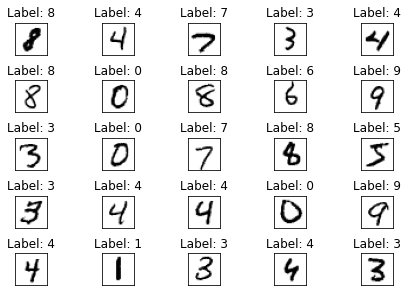

In [7]:
examples_iter = iter(train_dataloader)
example_data, example_labels = examples_iter.next()

fig, axs = plt.subplots(5, 5, constrained_layout=True, facecolor='white')
axs = axs.flat
for i in range(25):
    ax = axs[i]
    ax.imshow(example_data[i][0], cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Label: {example_labels[i].item()}')

## Build and train a model

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(28*28, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [9]:
# Learning rate
lr = 0.001

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
n_epochs = 10
for epoch in tqdm(range(n_epochs), desc='Epochs'):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

Epochs: 100%|██████████| 10/10 [00:31<00:00,  3.15s/it]


## Test model

In [11]:
with torch.no_grad():
    labels_all = []
    predictions_all = []
    for images, labels in tqdm(test_dataloader, total=len(test_dataloader)):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits.data, 1)
        for label in labels:
            labels_all.append(int(label))
        for prediction in predicted:
            predictions_all.append(int(prediction))

100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


In [12]:
print(classification_report(labels_all, predictions_all))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.96      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



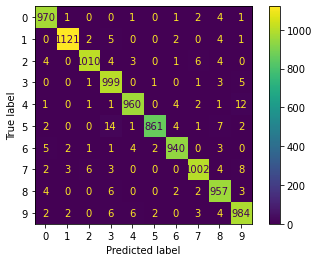

In [13]:
cm = confusion_matrix(labels_all, predictions_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()